In [1]:
# copy from 
# https://github.com/trnkatomas/Keras_2_examples/blob/master/Simple_LSTM_keras_2.0.ipynb

import keras
import tensorflow as tf
%matplotlib inline
import os, sys
# os.environ["CUDA_VISIBLE_DEVICES"]="1"

Using TensorFlow backend.


In [2]:
print("python:{}, keras:{}, tensorflow: {}".format(sys.version, keras.__version__, tf.__version__))

python:3.5.3 (default, Jan 19 2017, 14:11:04) 
[GCC 6.3.0 20170118], keras:2.0.4, tensorflow: 1.1.0


In [3]:
from keras.models import Sequential  
from keras.layers.core import Dense, Activation  
from keras.layers.recurrent import LSTM

in_neurons = 2  
out_neurons = 1  
hidden_neurons = 300

model = Sequential()
model.add(LSTM(hidden_neurons, return_sequences=False,
               input_shape=(None, in_neurons)))
model.add(Dense(out_neurons, input_dim=hidden_neurons))  
model.add(Activation("linear"))  
model.compile(loss="mean_squared_error", optimizer="rmsprop")  

In [4]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 300)               363600    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 301       
_________________________________________________________________
activation_1 (Activation)    (None, 1)                 0         
Total params: 363,901
Trainable params: 363,901
Non-trainable params: 0
_________________________________________________________________


In [5]:
import pandas as pd  
from random import random
import numpy as np

# option 1: original blog post
#flow = (list(range(1,10,1)) + list(range(10,1,-1)))*100
#print(flow)

# option 2: pure random data
#n_samples = 1790
#flow = np.random.uniform(0, 1, (n_samples))

# option 3: sinusoidal
#N = 1790
#sigma = 0.1
#xt=np.arange(0,N/10,1/10)
#flow = 1*np.sin(1*xt) + np.random.normal(0, sigma, N) +1 # first sine wave

# option 4: sinusoidal with lagged dependency
N = 1790
sigma = 0.5
xt=np.arange(0,N/10,1/10)
flow1 = 1*np.sin(1*xt) + np.random.normal(0, sigma, N) +1 # first sine wave
flow2 = 1*np.cos(1*xt) + np.random.normal(0, sigma, N) +1 # second sine wave

# Do not pass in flow2 into the model. LSTM should figure it out , "b":flow2})
pdata = pd.DataFrame({"a":flow1, "b": 0*flow2})
#pdata.b = pdata.b.shift(9)
# data = pdata.iloc[10:] * random()  # some noise
data = pdata
print(data.shape)

y = pd.DataFrame({"c":flow1+flow2})
print(y.shape)

(1790, 2)
(1790, 1)


/home/shadi/.local/share/virtualenvs/G2ML/lib/python3.5/site-packages/matplotlib/legend.py:634: UserWarning: Legend does not support 'X' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#using-proxy-artist
  "#using-proxy-artist".format(orig_handle)


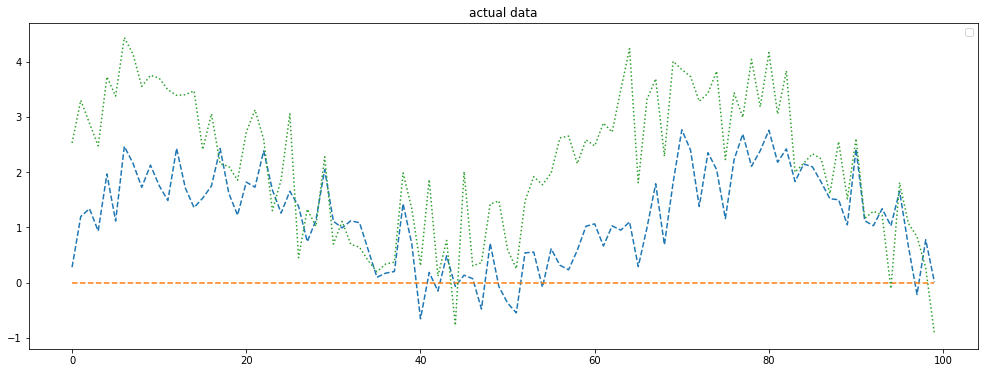

In [6]:
import matplotlib.pylab as plt
plt.rcParams["figure.figsize"] = (17, 6)

#plt.plot(pdata[:100])
#plt.show()
plt.plot(data[:100],'--')
plt.plot(y[:100],':')
plt.legend("X","y")
plt.title("actual data")
plt.show()

In [30]:
# import numpy as np

def _load_data_original(data, y, n_prev = 100):  
    """
    data should be pd.DataFrame()
    """

    docX, docY = [], []
    for i in range(len(data)-n_prev):
        docX.append(data.iloc[i:i+n_prev].as_matrix())
        docY.append(y.iloc[i+n_prev].as_matrix())
    alsX = np.array(docX)
    alsY = np.array(docY)

    return alsX, alsY

# https://stackoverflow.com/a/21230438/4126114
# Testing:
#    running_view(np.array([1,2,3,4,5,6,7,8,9,10]),3,0)
#    running_view(np.array([[1,2],[3,4],[5,6],[7,8],[9,10]]),3,0)
def running_view(arr, window, axis=-1):
    """
    return a running view of length 'window' over 'axis'
    the returned array has an extra last dimension, which spans the window
    """
    shape = list(arr.shape)
    shape[axis] -= (window-1)
    assert(shape[axis]>0)
    return np.lib.index_tricks.as_strided(
        arr,
        shape + [window],
        arr.strides + (arr.strides[axis],))

def _load_data_strides(data, y, n_prev = 100):  
    """
    data should be pd.DataFrame()
    """
    docX = running_view(data.values, n_prev, 0)
    docX = np.array([y.T for y in docX])
    docY = y.values[n_prev:,:]
    return docX, docY

def train_test_split(df, y, test_size=0.1):  
    """
    This just splits data to training and testing parts
    """
    ntrn = round(len(df) * (1 - test_size))

    #X_train, y_train = _load_data(df.iloc[0:ntrn], y.iloc[0:ntrn])
    #X_test, y_test = _load_data(df.iloc[ntrn:], y.iloc[ntrn:])
    # alternative to the for loop in the original load data
    # Note that both the original load data and the stride consume a lot of memory
    X_train, y_train = _load_data_strides(df.iloc[0:ntrn], y.iloc[0:ntrn])
    X_test, y_test = _load_data_strides(df.iloc[ntrn:], y.iloc[ntrn:])

    return (X_train, y_train), (X_test, y_test)

print('done')

done


(1790, 2) (1790, 1)
(1512, 100, 2) (1511, 1) (80, 100, 2) (79, 1)


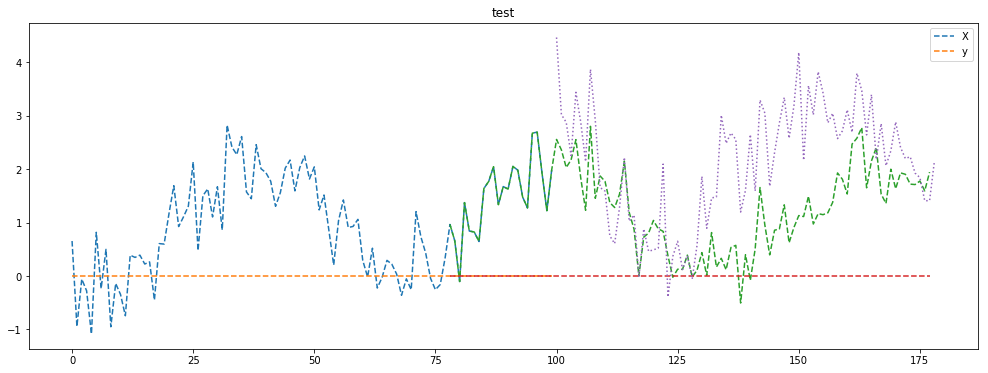

In [31]:
(X_train, y_train), (X_test, y_test) = train_test_split(data, y)  # retrieve data
print(data.shape,y.shape)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

#x2 = [100+x for x in range(len(y_test))]
#print(len(x2),x2)

plt.plot(X_test[0], "--")
plt.plot([78+x for x in range(100)],X_test[78], "--")
plt.plot([100+x for x in range(len(y_test))],y_test[:100],":")
plt.legend(["X", "y"])
plt.title('test')
plt.show()

In [9]:
# and now train the model
# batch_size should be appropriate to your memory size
# number of epochs should be higher for real world problems
epochs=10 # FIXME # 10
model.fit(X_train, y_train, batch_size=450, epochs=epochs, validation_split=0.05)

Train on 1435 samples, validate on 76 samples
Epoch 1/10
1435/1435 [==============================] - 36s - loss: 10.4001 - val_loss: 2.2875
Epoch 2/10
1435/1435 [==============================] - 33s - loss: 2.5600 - val_loss: 1.6152
Epoch 3/10
1435/1435 [==============================] - 32s - loss: 1.5158 - val_loss: 1.2704
Epoch 4/10
1435/1435 [==============================] - 33s - loss: 1.4192 - val_loss: 1.1771
Epoch 5/10
1435/1435 [==============================] - 35s - loss: 1.3322 - val_loss: 1.1872
Epoch 6/10
1435/1435 [==============================] - 35s - loss: 1.3523 - val_loss: 1.1448
Epoch 7/10
1435/1435 [==============================] - 33s - loss: 1.2257 - val_loss: 0.8103
Epoch 8/10
1435/1435 [==============================] - 33s - loss: 1.0741 - val_loss: 1.6101
Epoch 9/10
1435/1435 [==============================] - 33s - loss: 1.2728 - val_loss: 0.5545
Epoch 10/10
1435/1435 [==============================] - 34s - loss: 0.8906 - val_loss: 0.6570


In [10]:
predicted = model.predict(X_test)  
rmse = np.sqrt(((predicted - y_test) ** 2).mean(axis=0))
print(rmse)

[ 0.79343539]


(79, 1) (79, 1)


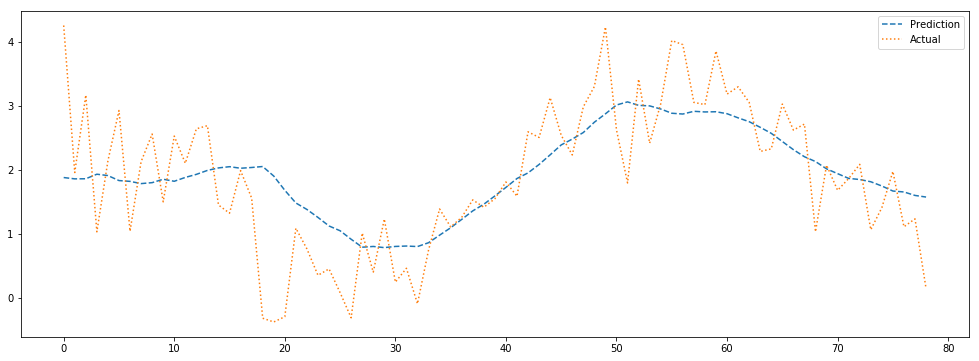

In [11]:
print(predicted.shape, y_test.shape)

plt.plot(predicted[:100],"--")
#plt.plot(predicted[:100][:,1],"--")
plt.plot(y_test[:100],":")
#plt.plot(y_test[:100][:,1],":")
plt.legend(["Prediction", "Actual"])
plt.show()